[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb)

# Multiclass Regression

In [39]:
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

# Simulate toy data

In [40]:
N = 150

X = np.column_stack((np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N)))

W_true = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [0,0,1]])

a = np.matmul(X, W_true)
y = np.zeros_like(a)
y[np.arange(len(a)), a.argmax(1)] = 1

In [41]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Split the data into training, validation, and testing

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Create Multinomial Logistic Regression model object

In [43]:
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

Check gradients

In [44]:
# check grad
print(mlr.check_grad(X_train, y_train))

1.0093739404449858e-18


Fitting the multinomial logistic model

iter 0: 47.870; 47.740
iter 1: 46.484; 46.729
iter 2: 45.213; 45.781
iter 3: 44.038; 44.887
iter 4: 42.946; 44.039
iter 5: 41.926; 43.232
iter 6: 40.969; 42.461
iter 7: 40.067; 41.721
iter 8: 39.214; 41.012
iter 9: 38.405; 40.329
iter 10: 37.635; 39.671
iter 11: 36.902; 39.037
iter 12: 36.202; 38.425
iter 13: 35.532; 37.835
iter 14: 34.890; 37.264
iter 15: 34.275; 36.713
iter 16: 33.684; 36.180
iter 17: 33.117; 35.664
iter 18: 32.571; 35.166
iter 19: 32.045; 34.684
iter 20: 31.539; 34.217
iter 21: 31.051; 33.765
iter 22: 30.580; 33.328
iter 23: 30.125; 32.904
iter 24: 29.687; 32.494
iter 25: 29.262; 32.096
iter 26: 28.853; 31.711
iter 27: 28.456; 31.337
iter 28: 28.073; 30.975
iter 29: 27.701; 30.623
iter 30: 27.342; 30.282
iter 31: 26.993; 29.951
iter 32: 26.656; 29.629
iter 33: 26.328; 29.317
iter 34: 26.011; 29.013
iter 35: 25.703; 28.718
iter 36: 25.403; 28.432
iter 37: 25.113; 28.153
iter 38: 24.831; 27.882
iter 39: 24.556; 27.618
iter 40: 24.290; 27.361
iter 41: 24.030; 27.110
it

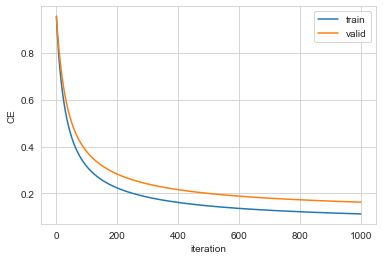

In [45]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

From the above plot, we can see that the training and validation error curves both continue to decrease. Therefore, there is no sign of overfitting.

In [46]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [47]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

1.0
1.0
0.96


In [48]:
print(mlr.W)
print(W_true)

[[-0.79830627  3.54033017 -1.67501333]
 [-1.60945539 -1.53732205  4.65376435]
 [ 5.80105343 -3.12929157 -1.6591362 ]
 [-1.39527866  0.45835665  3.22639578]]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


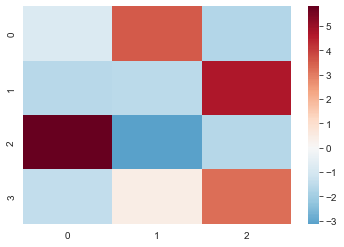

In [49]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

Plot as softmax

In [50]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]
W_hat_transformed

array([[1.35755302e-03, 9.49332193e-01, 1.43478971e-03],
       [6.03224831e-04, 5.91863925e-03, 8.04158168e-01],
       [9.97291922e-01, 1.20458733e-03, 1.45775187e-03],
       [7.47300003e-04, 4.35445807e-02, 1.92949290e-01]])

Now plot the softmax-transformed heatmap, which looks almost identical to groundtruth.

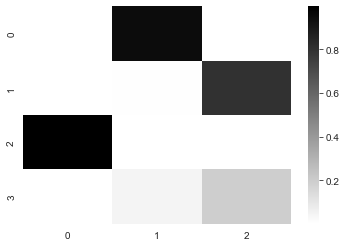

In [51]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

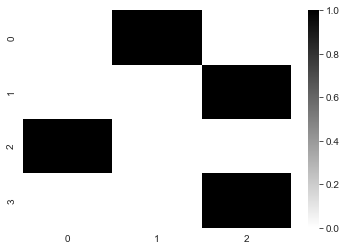

In [52]:
hmp = heatmap(W_true, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_true.png")

# Iris flower classification

In [53]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

print(iris['target_names']) # print flower types
print(iris['feature_names']) # print flower feature names

X = iris.data
y_cat = iris.target

# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

print(y)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 

Once again, we split the data into training, testing, and validation

In [54]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [55]:
mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))

1.3027108335164026e-18


iter 0: 42.849; 47.127
iter 1: 35.982; 40.000
iter 2: 31.748; 35.588
iter 3: 28.944; 32.673
iter 4: 26.945; 30.606
iter 5: 25.432; 29.051
iter 6: 24.234; 27.828
iter 7: 23.253; 26.831
iter 8: 22.428; 25.997
iter 9: 21.720; 25.284
iter 10: 21.103; 24.665
iter 11: 20.558; 24.121
iter 12: 20.072; 23.637
iter 13: 19.634; 23.202
iter 14: 19.236; 22.808
iter 15: 18.872; 22.449
iter 16: 18.538; 22.120
iter 17: 18.228; 21.817
iter 18: 17.940; 21.536
iter 19: 17.672; 21.274
iter 20: 17.420; 21.030
iter 21: 17.183; 20.801
iter 22: 16.959; 20.586
iter 23: 16.747; 20.383
iter 24: 16.545; 20.191
iter 25: 16.354; 20.009
iter 26: 16.170; 19.836
iter 27: 15.995; 19.671
iter 28: 15.827; 19.513
iter 29: 15.666; 19.362
iter 30: 15.510; 19.218
iter 31: 15.360; 19.079
iter 32: 15.216; 18.946
iter 33: 15.076; 18.817
iter 34: 14.940; 18.693
iter 35: 14.809; 18.573
iter 36: 14.681; 18.458
iter 37: 14.557; 18.345
iter 38: 14.437; 18.237
iter 39: 14.319; 18.131
iter 40: 14.205; 18.029
iter 41: 14.093; 17.929
it

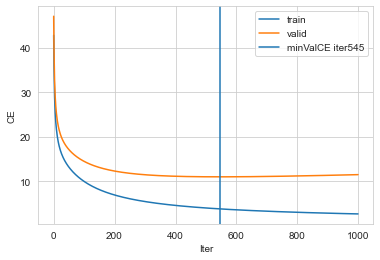

In [56]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)
optimal_niter = ce_valid.argmin()

plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.axvline(x=optimal_niter, label=f"minValCE iter{optimal_niter}")
plt.legend()
plt.xlabel("Iter")
plt.ylabel("CE")
plt.savefig("iris_training_ce.png", bbox_inches="tight", dpi=300)

In [57]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
_, _ = mlr.fit(X_train, y_train, niter=optimal_niter) # retrain the model using best niter

iter 0: 48.031
iter 1: 40.106
iter 2: 35.346
iter 3: 32.235
iter 4: 30.041
iter 5: 28.396
iter 6: 27.105
iter 7: 26.054
iter 8: 25.174
iter 9: 24.421
iter 10: 23.764
iter 11: 23.184
iter 12: 22.665
iter 13: 22.195
iter 14: 21.767
iter 15: 21.374
iter 16: 21.010
iter 17: 20.671
iter 18: 20.355
iter 19: 20.058
iter 20: 19.778
iter 21: 19.513
iter 22: 19.261
iter 23: 19.022
iter 24: 18.793
iter 25: 18.574
iter 26: 18.364
iter 27: 18.162
iter 28: 17.968
iter 29: 17.780
iter 30: 17.599
iter 31: 17.423
iter 32: 17.253
iter 33: 17.089
iter 34: 16.928
iter 35: 16.772
iter 36: 16.621
iter 37: 16.473
iter 38: 16.329
iter 39: 16.188
iter 40: 16.051
iter 41: 15.916
iter 42: 15.785
iter 43: 15.657
iter 44: 15.531
iter 45: 15.407
iter 46: 15.286
iter 47: 15.168
iter 48: 15.052
iter 49: 14.937
iter 50: 14.825
iter 51: 14.715
iter 52: 14.607
iter 53: 14.501
iter 54: 14.396
iter 55: 14.294
iter 56: 14.192
iter 57: 14.093
iter 58: 13.995
iter 59: 13.899
iter 60: 13.804
iter 61: 13.710
iter 62: 13.618
it

Check classification accuracy on training, validation, and testing sets

In [58]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.98
0.9
0.96


Visualize feature weights for each flower class

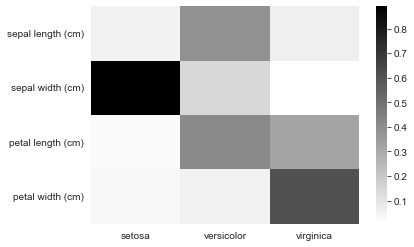

In [59]:
W_hat = mlr.W[:-1,:] # remove the intercept
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]

import pandas as pd
iris = datasets.load_iris()
feature_names = iris['feature_names'].copy()
label_names = iris['target_names'].tolist()

W_hat_transformed_df = pd.DataFrame(W_hat_transformed, columns=label_names, index=feature_names)
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("iris_W_hat_transformed.png", bbox_inches="tight", dpi=300)